In [2]:
import numpy as np   # linear algebra
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
## unzip files
# import glob
# import zipfile

In [4]:
# files = glob.glob('model_input/cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip')
# print(files)

In [5]:
# for file in files:
#     print('Unzipping:',file)
#     print(file)
#     with zipfile.ZipFile(file, 'r') as zip_ref:
#         zip_ref.extractall('model_input/cassava-leaf-disease-classification')

In [6]:
!pip install timm
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [7]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import cv2
import torch.optim as optim
import torchvision.models as models
import torchvision

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import ViTModel
from torch.optim.lr_scheduler import StepLR

from transformers import ViTForImageClassification,ViTConfig,AutoModel

from statistics import mean

plt.style.use('fivethirtyeight')

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
use_cuda, device

(True, device(type='cuda'))

In [9]:
BASE_PATH = 'model_input/cassava-leaf-disease-classification'

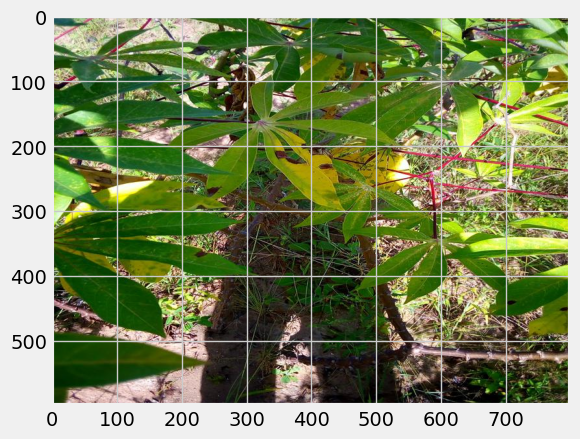

(600, 800, 3)

In [10]:
image = cv2.imread(BASE_PATH+'/train_images/1000015157.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
image.shape

In [101]:
# parameters
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 1e-4
EPOCHS = 10
num_classes = 5

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
model_name="google/vit-base-patch16-224"
saving_dir="adding_gaussion_noise_save_pretrained"

In [102]:
train = pd.read_csv(BASE_PATH+'/train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [103]:
#train = train[:1000]

In [104]:
train.shape

(21397, 2)

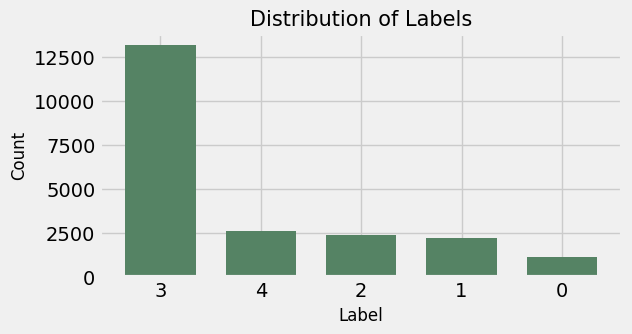

In [105]:
plt.figure(figsize=(6, 3))

train['label'].value_counts().plot(
    kind='bar',
    color='#558364',
    width=0.7
)

plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Labels', fontsize=15)
plt.xticks(rotation=360)
plt.show()

In [106]:
train_df, val_df = model_selection.train_test_split(
    train, test_size=0.12, random_state=42, stratify=train['label'].values
)

In [107]:
class LeafDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, data_path=BASE_PATH, mode='train', transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms 
        self.mode = mode
        self.data_dir = 'train_images' if mode == 'train' else 'test_images'
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, label

In [108]:
# gaussian noise class
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [109]:
# adding gaussian noise to train_dataset 
# transforms_train = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomHorizontalFlip(p=0.2),
#     transforms.RandomVerticalFlip(p=0.2),
#     transforms.RandomResizedCrop(IMG_SIZE),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std),
#     AddGaussianNoise(0, 1)
# ])

# transforms_val = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)
# ])

In [110]:
# adding gaussian noise to train_dataset in transform
transforms_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    AddGaussianNoise(0.485, 0.229)
])

transforms_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [111]:
train_dataset = LeafDataset(df=train_df, data_path=BASE_PATH, mode='train', transforms=transforms_train)
val_dataset = LeafDataset(df=val_df, data_path=BASE_PATH, mode='train', transforms=transforms_val)

In [112]:
train_dataset[1]

(tensor([[[ 1.1372,  1.0790,  0.4954,  ...,  0.5954,  0.1458,  0.1573],
          [ 1.5621,  1.5775,  1.5779,  ...,  0.9311,  0.7463,  0.8127],
          [ 1.5488,  1.7554,  2.0031,  ...,  0.9493,  0.9131,  0.4485],
          ...,
          [-1.2241, -1.0315, -0.4435,  ..., -1.2935, -1.4115, -1.4701],
          [-1.1324, -0.2934, -0.5471,  ..., -1.4347, -1.6298, -1.3319],
          [-0.2497, -0.2422, -0.5394,  ..., -1.4072, -1.3113, -0.9637]],
 
         [[ 1.2309,  1.4810,  2.0395,  ...,  0.8260,  0.1307,  0.3689],
          [ 2.0150,  1.9205,  2.0157,  ...,  0.1501,  0.3605,  0.6231],
          [ 2.2110,  2.3519,  2.0414,  ...,  1.3207,  0.0070,  0.4303],
          ...,
          [ 0.4741,  0.8163,  0.9782,  ..., -0.6603, -0.3121, -0.7283],
          [ 0.0722,  0.7072,  0.9015,  ..., -0.2229, -0.4654, -0.8434],
          [ 0.5272,  1.2582,  0.9435,  ..., -0.4177,  0.1234, -0.2802]],
 
         [[ 0.0151, -0.2948,  0.4315,  ...,  0.2959,  0.1341,  0.5497],
          [ 0.6819,  0.5903,

In [113]:
len(train_dataset), len(val_dataset)

(18829, 2568)

In [114]:
model = ViTForImageClassification.from_pretrained(model_name)
model.classifier = nn.Linear(in_features=768, out_features=num_classes, bias=True)
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [115]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

def train_model(model, train_dataset, val_dataset, learning_rate, epochs):

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_images, train_labels in tqdm(train_dataloader):
                
                train_images = train_images.to(device)
                train_labels = train_labels.to(device)
                
                optimizer.zero_grad()

                output = model(train_images)
                
                batch_loss = criterion(output.logits, train_labels.long())
                total_loss_train += batch_loss.item()
            
                _, predicted = torch.max(output.logits.data, 1)
                acc = (predicted == train_labels).sum().item()
                total_acc_train += acc

                batch_loss.backward()
                optimizer.step()
                
            scheduler.step()
            
            total_acc_val = 0
            total_loss_val = 0
            # model validation
            with torch.no_grad():

                for val_images, val_labels in val_dataloader:
                    
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    
                    output = model(val_images)

                    batch_loss = criterion(output.logits, val_labels.long())
                    total_loss_val += batch_loss.item()
                    
                    _, predicted = torch.max(output.logits.data, 1)
                    acc = (predicted == val_labels).sum().item()
                    total_acc_val += acc
            
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
            | Train Accuracy: {total_acc_train / len(train_dataset): .3f} \
            | Val Loss: {total_loss_val / len(val_dataset): .3f} \
            | Val Accuracy: {total_acc_val / len(val_dataset): .3f}')
            
            train_losses.append(total_loss_train / len(train_dataset))
            train_accs.append(total_acc_train / len(train_dataset))
            val_losses.append(total_loss_val / len(val_dataset))
            val_accs.append(total_acc_val / len(val_dataset))
    model.save_pretrained(saving_dir)

In [117]:
#EPOCHS=1
train_model(model, train_dataset, val_dataset, LR, EPOCHS)

100%|██████████| 1177/1177 [11:53<00:00,  1.65it/s]


Epochs: 1 | Train Loss:  0.038             | Train Accuracy:  0.781             | Val Loss:  0.034             | Val Accuracy:  0.813


100%|██████████| 1177/1177 [12:01<00:00,  1.63it/s]


Epochs: 2 | Train Loss:  0.031             | Train Accuracy:  0.826             | Val Loss:  0.030             | Val Accuracy:  0.825


100%|██████████| 1177/1177 [12:02<00:00,  1.63it/s]


Epochs: 3 | Train Loss:  0.028             | Train Accuracy:  0.841             | Val Loss:  0.029             | Val Accuracy:  0.839


100%|██████████| 1177/1177 [11:43<00:00,  1.67it/s]


Epochs: 4 | Train Loss:  0.026             | Train Accuracy:  0.855             | Val Loss:  0.029             | Val Accuracy:  0.836


100%|██████████| 1177/1177 [11:45<00:00,  1.67it/s]


Epochs: 5 | Train Loss:  0.024             | Train Accuracy:  0.866             | Val Loss:  0.030             | Val Accuracy:  0.838


100%|██████████| 1177/1177 [12:19<00:00,  1.59it/s]


Epochs: 6 | Train Loss:  0.022             | Train Accuracy:  0.877             | Val Loss:  0.031             | Val Accuracy:  0.836


100%|██████████| 1177/1177 [12:03<00:00,  1.63it/s]


Epochs: 7 | Train Loss:  0.020             | Train Accuracy:  0.887             | Val Loss:  0.029             | Val Accuracy:  0.848


100%|██████████| 1177/1177 [13:25<00:00,  1.46it/s]


Epochs: 8 | Train Loss:  0.018             | Train Accuracy:  0.898             | Val Loss:  0.032             | Val Accuracy:  0.837


100%|██████████| 1177/1177 [11:54<00:00,  1.65it/s]


Epochs: 9 | Train Loss:  0.016             | Train Accuracy:  0.912             | Val Loss:  0.034             | Val Accuracy:  0.833


100%|██████████| 1177/1177 [11:49<00:00,  1.66it/s]


Epochs: 10 | Train Loss:  0.014             | Train Accuracy:  0.921             | Val Loss:  0.033             | Val Accuracy:  0.835


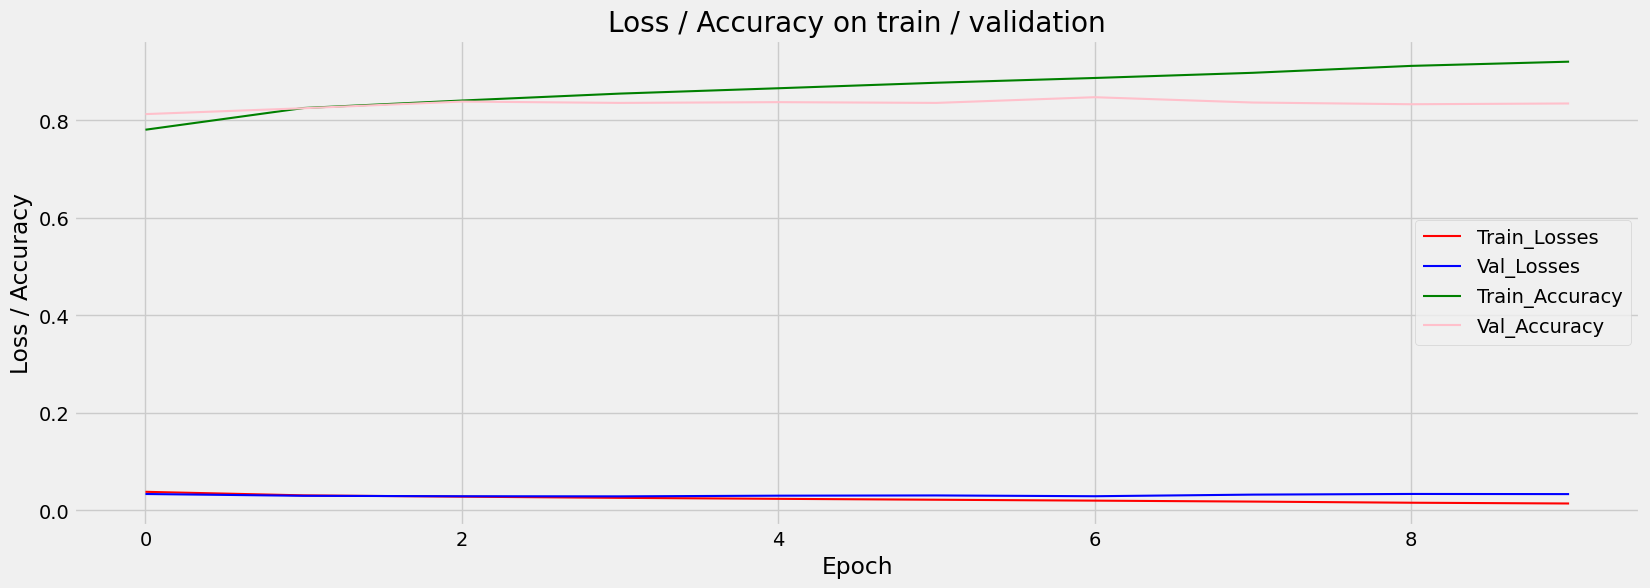

In [132]:
plt.figure(figsize=(18, 6))

plt.plot(
    train_losses, 
    label='Train_Losses', 
    color='red', 
    linewidth=1.5
)
plt.plot(
    val_losses, 
    label='Val_Losses', 
    color='blue', 
    linewidth=1.5
)

plt.plot(
    train_accs, 
    label='Train_Accuracy', 
    color='green', 
    linewidth=1.5
)
plt.plot(
    val_accs, 
    label='Val_Accuracy', 
    color='pink', 
    linewidth=1.5
)

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Loss / Accuracy on train / validation')
plt.legend()
plt.savefig("output_image/gaussian_noise_vit_loss_acc.jpg")
plt.show()

In [127]:
sub_df = pd.read_csv(BASE_PATH+'/sample_submission.csv')
sub_df.head()

,image_id,label
0,2216849948.jpg,4


In [128]:
test_dataset = LeafDataset(df=sub_df, data_path=BASE_PATH, mode='test', transforms=transforms_val)

def predict(model, test_dataset):
    preds = []
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    for test_images, test_labels in tqdm(test_dataloader):
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        output = model(test_images)
        _, predicted = torch.max(output.logits.data, 1)
        preds.extend(predicted.cpu().data.numpy())
        
    return preds    
preds=predict(model, test_dataset)

100%|██████████| 1/1 [00:00<00:00, 52.41it/s]


In [129]:
sub_df['label'] = preds
sub_df.to_csv('submission.csv', index=False)
sub_df.head()

,image_id,label
0,2216849948.jpg,2


In [130]:
pt_model = ViTForImageClassification.from_pretrained(saving_dir,num_labels = num_classes)
pt_model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [131]:
predict(pt_model, test_dataset)

100%|██████████| 1/1 [00:00<00:00, 52.71it/s]


[2]